In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


In [3]:
class NEUDETDatasetFolder(Dataset):
    def __init__(self, root_images_dir, transform=None):
        self.root_images_dir = root_images_dir
        self.transform = transform

        self.class_names = sorted([
            d for d in os.listdir(root_images_dir)
            if os.path.isdir(os.path.join(root_images_dir, d))
        ])
        if len(self.class_names) == 0:
            raise ValueError(f"Alt sınıf klasörü bulunamadı: {root_images_dir}")

        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

        valid_ext = (".jpg", ".jpeg", ".png", ".bmp")
        self.samples = []
        for cls in self.class_names:
            cls_dir = os.path.join(root_images_dir, cls)
            for fname in os.listdir(cls_dir):
                fpath = os.path.join(cls_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(valid_ext):
                    self.samples.append((fpath, self.class_to_idx[cls]))

        if len(self.samples) == 0:
            raise ValueError(f"Hiç resim bulunamadı: {root_images_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

train_images = "../train/images"
val_images   = "../validation/images"

train_dataset = NEUDETDatasetFolder(train_images, transform=train_transform)
val_dataset   = NEUDETDatasetFolder(val_images,   transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train:", len(train_dataset), "Val:", len(val_dataset))
print("Classes:", train_dataset.class_names)


Train: 1440 Val: 360
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = len(train_dataset.class_names)

model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

# Freeze backbone
for p in model.parameters():
    p.requires_grad = False

# Classifier değiştir (son linear katmanı)
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, num_classes)

# Sadece classifier trainable
for p in model.classifier.parameters():
    p.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

print("Trainable params:", sum(p.requires_grad for p in model.parameters()))


Device: cpu
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\KER9/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


100.0%


Trainable params: 4


In [6]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def get_preds_labels(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    for images, labels in loader:
        outputs = model(images.to(device))
        all_preds.append(outputs.argmax(dim=1).cpu().numpy())
        all_labels.append(labels.numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)


In [7]:
num_epochs = 10
best_val_acc = 0.0
best_state = None

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);   val_accs.append(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {va_loss:.4f} Acc {va_acc:.4f}")

print("Best Val Acc:", best_val_acc)


Epoch 01 | Train Loss 0.3664 Acc 0.8750 | Val Loss 0.8818 Acc 0.7611
Epoch 02 | Train Loss 0.0887 Acc 0.9715 | Val Loss 0.4949 Acc 0.7972
Epoch 03 | Train Loss 0.1086 Acc 0.9667 | Val Loss 0.3431 Acc 0.8556
Epoch 04 | Train Loss 0.0648 Acc 0.9799 | Val Loss 0.4499 Acc 0.7833
Epoch 05 | Train Loss 0.0760 Acc 0.9764 | Val Loss 1.4765 Acc 0.6611
Epoch 06 | Train Loss 0.0948 Acc 0.9736 | Val Loss 0.6679 Acc 0.7667
Epoch 07 | Train Loss 0.0405 Acc 0.9889 | Val Loss 1.0283 Acc 0.7000
Epoch 08 | Train Loss 0.0415 Acc 0.9847 | Val Loss 0.8564 Acc 0.7417
Epoch 09 | Train Loss 0.0503 Acc 0.9847 | Val Loss 0.3738 Acc 0.8500
Epoch 10 | Train Loss 0.0448 Acc 0.9826 | Val Loss 0.2313 Acc 0.9333
Best Val Acc: 0.9333333333333333


VAL(TEST) Metrics - MobileNetV3-Small (Frozen)
Accuracy:        0.9333
Macro Precision: 0.9442
Macro Recall:    0.9333
Macro F1-score:  0.9337


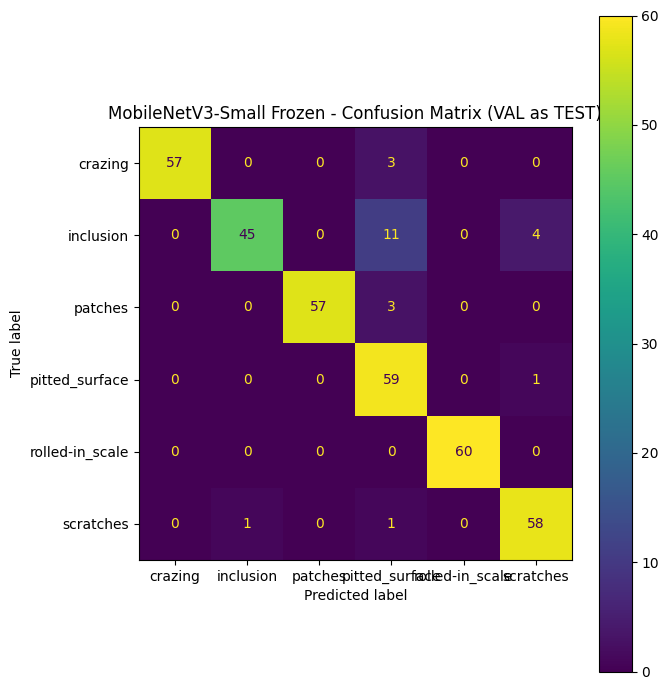

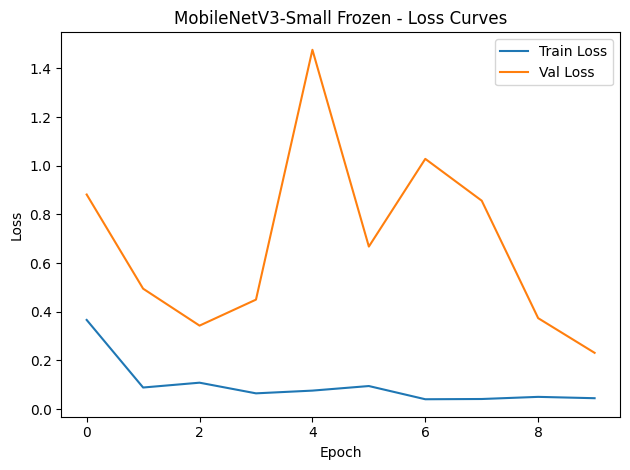

In [8]:
model.load_state_dict(best_state)
model = model.to(device)

y_pred, y_true = get_preds_labels(model, val_loader, device)

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)

print("VAL(TEST) Metrics - MobileNetV3-Small (Frozen)")
print(f"Accuracy:        {acc:.4f}")
print(f"Macro Precision: {prec:.4f}")
print(f"Macro Recall:    {rec:.4f}")
print(f"Macro F1-score:  {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, values_format="d")
plt.title("MobileNetV3-Small Frozen - Confusion Matrix (VAL as TEST)")
plt.tight_layout()
plt.savefig("mobilenetv3_small_frozen_confusion_matrix.png", dpi=300)
plt.show()

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("MobileNetV3-Small Frozen - Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("mobilenetv3_small_frozen_loss_curves.png", dpi=300)
plt.show()
